In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wfdb
import pandas as pd
import ast
import random
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

import data_visualisation as dv
import data_augmentation as da
# from PTBXL import PTBXL
import importlib

importlib.reload(dv)
importlib.reload(da)

<module 'data_augmentation' from '/home/raaif/Desktop/Uni/y4/FYP/data_augmentation.py'>

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [27]:

path = 'physionet.org/files/ptb-xl/1.0.3/'
sampling_rate=500

# load and convert annotation data
DF = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
DF.scp_codes = DF.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
print('Loading data...')
X = load_raw_data(DF, sampling_rate, path)
print('Data loaded.')

# Load scp_statements.csv for diagnostic aggregation
print('Loading scp_statements...')
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print('Scp statements loaded.')

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
DF['diagnostic_superclass'] = DF.scp_codes.apply(aggregate_diagnostic)

superclasses = np.unique([elem for sublist in DF.diagnostic_superclass for elem in sublist])



Z = pd.DataFrame(0, index=DF.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')
for i in Z.index:
    for k in DF.loc[i].diagnostic_superclass:
        Z.loc[i, k] = 1
        
test_fold = 10
val_fold = 9

X_train = X[np.where(DF.strat_fold <= 8)]
y_train = Z[(DF.strat_fold <= 8)]
y_train_text = DF[(DF.strat_fold <= 8)].diagnostic_superclass

X_val = X[np.where(DF.strat_fold == val_fold)]
y_val = Z[DF.strat_fold == val_fold]

X_test = X[np.where(DF.strat_fold == test_fold)]
y_test = Z[DF.strat_fold == test_fold]

Loading data...
Data loaded.
Loading scp_statements...
Scp statements loaded.


(5000, 12)


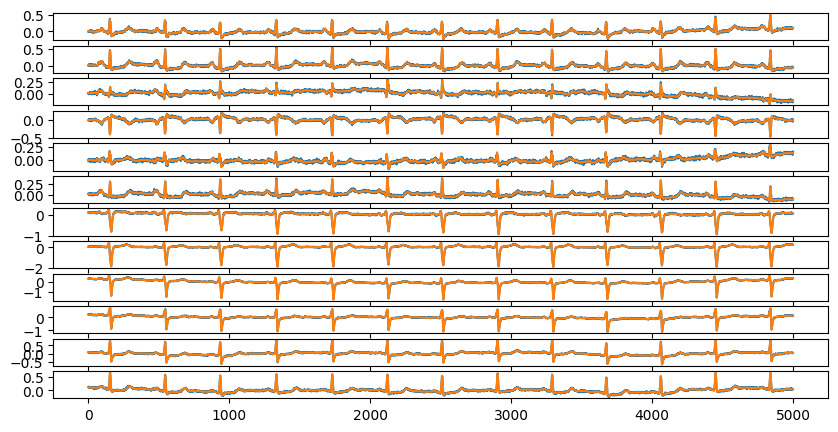

['NORM']
NORM    1
MI      0
STTC    0
CD      0
HYP     0
Name: 14985, dtype: int64


In [72]:
rand = random.randint(0, len(X_train))

sample = X_train[rand]
print(sample.shape)

augmented_sample = da.add_random_noise(sample, 0.1)
aug2 = da.add_random_baseline_drift(sample.transpose(0,1), strength=1)

bar, axes = plt.subplots(sample.shape[1], 1, figsize=(10,5))
for i in range(sample.shape[1]):
    # sns.lineplot(x=np.arange(sample.shape[0]), y=aug2[:, i], ax=axes[i])
    sns.lineplot(x=np.arange(sample.shape[0]), y=augmented_sample[:, i], ax=axes[i])
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
#plt.tight_layout()
plt.show()
print(y_train_text.iloc[rand])
print(y_train.iloc[rand])

In [73]:
from sklearn.preprocessing import StandardScaler



# Normalise data
X_scaler = StandardScaler()
X_scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

X_train = X_scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test  = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# convert x_train to tensors
# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train.values)


Train data shape:  (17418, 5000, 12)
Train labels shape:  (17418, 5)
Train labels text shape:  (17418,)
Random sample:  1641
Labels:  NORM    1
MI      0
STTC    0
CD      1
HYP     0
Name: 2196, dtype: int64
Labels:  ['NORM', 'CD']


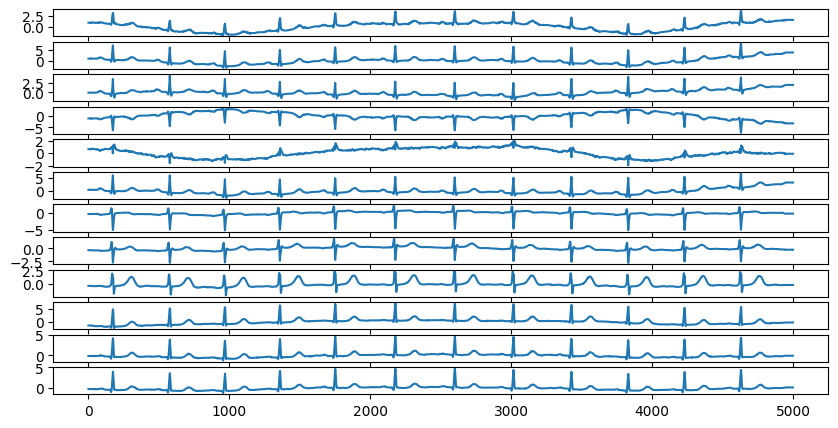

In [82]:
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Train labels text shape: ', y_train_text.shape)

rand_sample_i = random.randint(0, X_train.shape[0])
print('Random sample: ', rand_sample_i)
rand_sample = X_train[rand_sample_i]

bar, axes = plt.subplots(rand_sample.shape[1], 1, figsize=(10,5))
for i in range(rand_sample.shape[1]):
    sns.lineplot(x=np.arange(rand_sample.shape[0]), y=rand_sample[:, i], ax=axes[i])

print('Labels: ', y_train.iloc[rand_sample_i])
print('Labels: ', y_train_text.iloc[rand_sample_i])



In [4]:
# define a 1d cnn feature extractor

# class CNN1D(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(CNN1D, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=5)
#         self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
#         self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
#         self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
#         self.fc1 = nn.Linear(256*311, 128)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(2)
#         self.dropout = nn.Dropout(0.5)
        
#     def forward(self, x):
#         x = x.transpose(0,1)
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv3(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv4(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = x.flatten(start_dim=0)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x
    

In [29]:
# # train the model
# num_classes = len(superclasses)

# criteria = nn.BCEWithLogitsLoss()
# model = CNN1D(X_train[0].shape[0], num_classes)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# batch_size = 32

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model.to(device)

# epochs = 10

# for epoch in range(epochs):
#     model.train()
#     for i, (x, y) in enumerate(zip(X_train, y_train)):
#         x, y = x.float(), y.float()
#         x, y = x.to(device), y.to(device)
        
#         optimizer.zero_grad()
        
#         output = model(x)
#         loss = criteria(output, y)
#         loss.backward()
#         optimizer.step()
        
#         if i % 1000 == 0:
#             print(f'Epoch {epoch}, loss: {loss.item()}')
    # evaluate the model
    # model.eval()
    # with torch.no_grad():
    #     for i, (x, y) in enumerate(zip(X_val, y_val)):
    #         x = torch.tensor(x).float()
    #         y = torch.tensor(y).float()
            
    #         output = model(x)
    #         loss = criteria(output, y)
    #         if i % 100 == 0:
    #             print(f'Epoch {epoch}, validation loss: {loss.item()}')
                
            

cuda
Epoch 0, loss: 0.6808993220329285
Epoch 0, loss: 0.21690316498279572
Epoch 0, loss: 1.3930232524871826
Epoch 0, loss: 0.19615650177001953
Epoch 0, loss: 0.3155774772167206
Epoch 0, loss: 0.614264965057373
Epoch 0, loss: 0.5946287512779236
Epoch 0, loss: 0.5334958434104919
Epoch 0, loss: 0.43004822731018066
Epoch 0, loss: 0.7012521624565125
Epoch 0, loss: 0.21583209931850433
Epoch 0, loss: 0.6426414847373962
Epoch 0, loss: 0.23521935939788818
Epoch 0, loss: 0.6829420328140259
Epoch 0, loss: 0.28854498267173767
Epoch 0, loss: 0.08954039961099625
Epoch 0, loss: 0.23313124477863312
Epoch 0, loss: 0.09124517440795898
Epoch 0, loss: 0.6399822235107422
Epoch 0, loss: 0.7681297659873962
Epoch 0, loss: 0.8147295117378235
Epoch 0, loss: 0.7644445896148682
Epoch 0, loss: 0.13671354949474335
Epoch 0, loss: 0.33455753326416016
Epoch 0, loss: 0.5055855512619019
Epoch 0, loss: 0.14041654765605927
Epoch 0, loss: 0.24412846565246582
Epoch 0, loss: 0.7567104697227478
Epoch 0, loss: 0.09384062141180

TypeError: new(): invalid data type 'str'

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
# import keras

num_classes = 5 #len(superclasses)

# Define the input shape
input_shape = (5000, 12)  # 5000 time points, 12 leads

model = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=input_shape),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(2),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPool1D(2),
    # keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    # keras.layers.MaxPool1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4991, 32)          3872      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2495, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2491, 64)          10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1245, 64)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 1241, 128)         41088     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 620, 128)        

In [107]:
with tf.device('CPU:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train.values))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val.values))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test.values))

In [108]:
train_dataset = train_dataset.shuffle(len(X_train)).batch(32)
val_dataset = val_dataset.batch(32)
test_dataset = test_dataset.batch(32)

In [109]:
history = model.fit(train_dataset, epochs=5, batch_size=32, validation_data=val_dataset)

: 

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
 

num_classes = 5 #len(superclasses)

model2 = keras.Sequential([
    keras.layers.LSTM(64, input_shape=(5000, 12), return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'F1Score'])
model2.summary()

huh
a
b
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5000, 64)          19712     
                                                                 
 batch_normalization_4 (Batc  (None, 5000, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 5000, 64)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)       

In [24]:
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
 23/175 ━━━━━━━━━━━━━━━━━━━━ 5:07 2s/step - AUC: 0.5519 - F1Score: 0.2346 - Precision: 0.2993 - Recall: 0.1317 - accuracy: 0.2705 - loss: 0.8249

KeyboardInterrupt: 

In [23]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
import torch

torch.cuda.is_available()

True